In [3]:
import os
import json
from PIL import Image

# Fixed mapping from class name to YOLO class id
CLASS_NAME_TO_ID = {
    'bike': 0, 
    'bus': 1, 
    'car': 2, 
    'motor': 3, 
    'person': 4, 
    'rider': 5, 
    'traffic light': 6, 
    'traffic sign': 7, 
    'train': 8, 
    'truck': 9,
}

# Categories that should be ignored (no YOLO labels for these)
IGNORED_CATEGORIES = {"lane", "drivable area"}


def get_image_size(image_path):
    """Return image size as (width, height)."""
    with Image.open(image_path) as img:
        return img.size  # (width, height)


def bbox_to_yolo(x1, y1, x2, y2, img_w, img_h):
    """
    Convert box2d (x1, y1, x2, y2) to YOLO (x_center, y_center, width, height),
    normalized to [0, 1].
    """
    box_w = x2 - x1
    box_h = y2 - y1
    x_center = x1 + box_w / 2.0
    y_center = y1 + box_h / 2.0

    # Normalize to [0, 1]
    x_center /= img_w
    y_center /= img_h
    box_w /= img_w
    box_h /= img_h

    return x_center, y_center, box_w, box_h


def index_images(image_dir):
    """
    Walk through image_dir recursively and build a mapping:
    basename -> full path
    """
    image_paths = {}
    for root, dirs, files in os.walk(image_dir):
        for fname in files:
            # you can restrict to certain extensions if needed
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                full_path = os.path.join(root, fname)
                base = os.path.basename(fname)
                if base in image_paths:
                    print(f"[WARNING] Duplicate image name detected: {base}")
                image_paths[base] = full_path
    print(f"[INFO] Indexed {len(image_paths)} images under {image_dir}")
    return image_paths


def convert_json_to_yolo(image_dir, json_path):
    """
    Convert custom JSON annotations to YOLO txt files.

    image_dir: folder containing images (recursively searched)
    json_path: path to the JSON annotation file

    All txt files will be written into: image_dir/labels
    """
    # Always write into a 'labels' subfolder inside image_dir
    labels_dir = os.path.join(image_dir, "labels")
    os.makedirs(labels_dir, exist_ok=True)

    # Index all images under image_dir recursively
    image_paths = index_images(image_dir)

    # Load JSON
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # If the root is a single dict, wrap it into a list
    if isinstance(data, dict):
        data = [data]

    for frame in data:
        img_name = frame.get("name")
        if not img_name:
            continue

        # Use only the basename to match with indexed images
        base_name = os.path.basename(img_name.strip())
        img_path = image_paths.get(base_name, None)

        if img_path is None:
            print(f"[WARNING] Image not found in index, skipping: {img_name}")
            continue

        try:
            img_w, img_h = get_image_size(img_path)
        except Exception as e:
            print(f"[ERROR] Cannot open image ({img_path}): {e}")
            continue

        labels = frame.get("labels", [])
        yolo_lines = []

        for obj in labels:
            category = obj.get("category")
            if not category:
                continue

            # Skip lanes and drivable areas
            if category in IGNORED_CATEGORIES:
                continue

            # Skip objects without box2d (e.g., polygons only)
            box2d = obj.get("box2d")
            if not box2d:
                continue

            # Skip categories not in CLASS_NAME_TO_ID
            if category not in CLASS_NAME_TO_ID:
                print(f"[INFO] Category '{category}' not in CLASS_NAME_TO_ID, skipping.")
                continue

            class_id = CLASS_NAME_TO_ID[category]

            x1 = box2d["x1"]
            y1 = box2d["y1"]
            x2 = box2d["x2"]
            y2 = box2d["y2"]

            x_c, y_c, w, h = bbox_to_yolo(x1, y1, x2, y2, img_w, img_h)

            line = f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"
            yolo_lines.append(line)

        # One txt file per image, inside labels folder
        txt_name = os.path.splitext(base_name)[0] + ".txt"
        txt_path = os.path.join(labels_dir, txt_name)

        with open(txt_path, "w", encoding="utf-8") as f:
            f.write("\n".join(yolo_lines))

    # Write classes.txt (one class name per line, in id order) into labels folder
    classes_txt_path = os.path.join(labels_dir, "classes.txt")
    with open(classes_txt_path, "w", encoding="utf-8") as f:
        for cname, cid in sorted(CLASS_NAME_TO_ID.items(), key=lambda x: x[1]):
            f.write(cname + "\n")

    print(f"[OK] Conversion finished. YOLO labels folder: {labels_dir}")
    print(f"[OK] Class list saved to: {classes_txt_path}")


image_dir = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/val"          
json_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json"  

convert_json_to_yolo(image_dir, json_path)

[INFO] Indexed 10000 images under /media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/val
[OK] Conversion finished. YOLO labels folder: /media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/val/labels
[OK] Class list saved to: /media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/val/labels/classes.txt


In [1]:
from ultralytics import YOLO

model = YOLO("yolo12n.pt")

results = model.train(
    data="/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/data.yaml",   
    epochs=100,         
    imgsz=640,          
    batch=32,           
    device=0,           
    workers=8,          
    amp=True,           
)

Ultralytics 8.3.229 🚀 Python-3.12.7 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5090 Laptop GPU, 23982MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fals

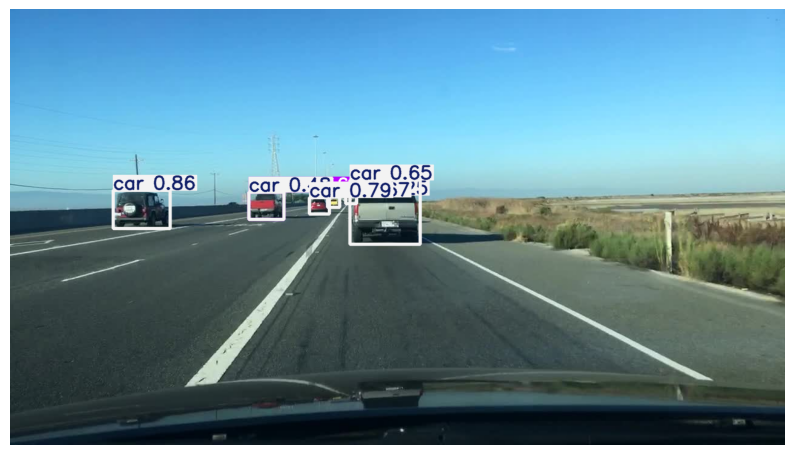

Detections:
 - car (id=2), conf=0.86, xyxy=[170.71810913085938, 299.1543273925781, 264.95404052734375, 362.4341125488281]
 - car (id=2), conf=0.79, xyxy=[494.9320068359375, 311.9742126464844, 527.94677734375, 338.7447204589844]
 - car (id=2), conf=0.67, xyxy=[524.61376953125, 310.86279296875, 544.551513671875, 327.6065673828125]
 - car (id=2), conf=0.65, xyxy=[561.9482421875, 282.73040771484375, 677.5830078125, 388.17449951171875]
 - car (id=2), conf=0.48, xyxy=[394.4176025390625, 302.3802795410156, 452.1263427734375, 347.0221252441406]
 - truck (id=9), conf=0.46, xyxy=[394.37835693359375, 302.71746826171875, 452.64080810546875, 347.01055908203125]
 - car (id=2), conf=0.25, xyxy=[554.4940185546875, 307.5403747558594, 572.049072265625, 321.9827575683594]


In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

%matplotlib inline
model_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/notebooks/runs/detect/train/weights/best.pt"  
# image_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/test/dc1bb31e-3cb2e900.jpg"            
# image_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/test/cc6ed4c9-ffb94309.jpg"
# image_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/test/d98457bb-6e42ca93.jpg"
# image_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/test/dafdd167-58a31c95.jpg"
# image_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/test/dc5d186e-cc58f8c2.jpg"
image_path = "/media/kursat/TOSHIBA_EXT/projects/routhwise/driverms/data/bdd100k/bdd100k/bdd100k/images/train/0a0a0b1a-7c39d841.jpg"

model = YOLO(model_path)

results = model.predict(
    source=image_path,
    imgsz=640,
    conf=0.25,
    device=0,
    verbose=False
)

result = results[0]
annotated_img = result.plot()  

plt.figure(figsize=(10, 10))
plt.imshow(annotated_img[..., ::-1])  
plt.axis("off")
plt.show()


print("Detections:")
for box in result.boxes:
    cls_id = int(box.cls[0].item())
    conf = float(box.conf[0].item())
    name = result.names[cls_id]
    xyxy = box.xyxy[0].tolist()
    print(f" - {name} (id={cls_id}), conf={conf:.2f}, xyxy={xyxy}")
